In [3]:
%matplotlib inline
from matplotlib import pyplot as plt

import pandas as pd
import numpy as np

from mxnet import autograd, gluon, init, nd

In [28]:
df_train = pd.read_csv('../data/kaggle_house_pred_train.csv')
df_test = pd.read_csv('../data/kaggle_house_pred_test.csv')
print(df_train.shape, df_test.shape)
print(df_train.columns)

(1460, 81) (1459, 80)
Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'Ga

In [29]:
df_data = pd.concat((df_train.iloc[:, 1:-1], df_test.iloc[:, 1:]))
print(df_data.shape)
print(df_data.columns)

(2919, 79)
Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'Paved

In [30]:
numeric_features = df_data.dtypes[df_data.dtypes != 'object'].index
df_data[numeric_features] = df_data[numeric_features].apply(lambda x: (x - x.mean()) / x.std())
df_data[numeric_features] = df_data[numeric_features].fillna(0)

In [31]:
df_data = pd.get_dummies(df_data, dummy_na=True)
df_data.shape

(2919, 331)

In [32]:
n_train = df_train.shape[0]
X_train = nd.array(df_data[:n_train].values)
X_test  = nd.array(df_data[n_train:].values)
y_train = nd.array(df_train['SalePrice'].values).reshape((-1, 1))
print(X_train.shape, y_train.shape, X_test.shape)

(1460, 331) (1460, 1) (1459, 331)


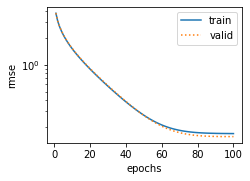

fold 0, train rmse 0.169488, valid rmse 0.156765
fold 1, train rmse 0.162322, valid rmse 0.189658
fold 2, train rmse 0.163822, valid rmse 0.168188
fold 3, train rmse 0.167451, valid rmse 0.154598
fold 4, train rmse 0.162710, valid rmse 0.182759
5-fold validation: avg train rmse 0.165159, avg valid rmse 0.170394


In [33]:
loss = gluon.loss.L2Loss()

def get_net():
    net = gluon.nn.Sequential()
    net.add(
        gluon.nn.Dense(1)
    )
    net.initialize()
    return net

def log_rmse(net, X, y):
    y_pred = nd.clip(net(X), 1, float('inf'))
    rmse = nd.sqrt(2*loss(y_pred.log(), y.log()).mean())
    return rmse.asscalar()

def train(net, X_train, y_train, X_test, y_test, num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = gluon.data.DataLoader(
        gluon.data.ArrayDataset(X_train, y_train), 
        batch_size, shuffle=True
    )
    trainer = gluon.Trainer(net.collect_params(), 'adam', {'learning_rate': learning_rate, 'wd': weight_decay})
    for ep in range(1, num_epochs+1):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X), y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net, X_train, y_train))
        if y_test is not None:
            test_ls.append(log_rmse(net, X_test, y_test))
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j*fold_size, (j+1)*fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid

def semilogy(
    x_vals, y_vals, 
    x_label, y_label, 
    x2_vals=None, y2_vals=None, 
    legend=None, figsize=(3.5, 2.5)):
    plt.rcParams['figure.figsize'] = figsize
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)
    plt.show()
    return

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    train_l_sum = 0
    valid_l_sum = 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(
                range(1, num_epochs+1), train_ls, 'epochs', 'rmse', 
                range(1, num_epochs+1), valid_ls, 
                ['train', 'valid']
            )
        print('fold %d, train rmse %f, valid rmse %f' %(i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, X_train, y_train, num_epochs, lr, weight_decay, batch_size)
print('%d-fold validation: avg train rmse %f, avg valid rmse %f' % (k, train_l, valid_l))

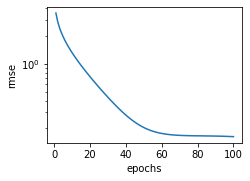

train rmse 0.162439
     Id      SalePrice
0  1461  119396.562500
1  1462  153959.265625
2  1463  198679.421875


In [34]:
def train_and_pred(X_train, X_test, y_train, df_test, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, X_train, y_train, None, None, num_epochs, lr, weight_decay, batch_size)
    semilogy(
        range(1, num_epochs+1), train_ls, 'epochs', 'rmse'
    )
    print('train rmse %f' % train_ls[-1])
    preds = net(X_test).asnumpy()
    df_test['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = df_test[['Id', 'SalePrice']]
    print(submission[:3])
    submission.to_csv('house_price_submission.csv', index=False)
    return 

train_and_pred(X_train, X_test, y_train, df_test, num_epochs, lr, weight_decay, batch_size)